# SARSA (On-policy, TD Learning)

In [ ]:
!git clone https://github.com/henritomas/cs295-rl

In [ ]:
%cd /content/cs295-rl

# SARSA



Q-Learning is OFF policy, meaning the updates made to the Q-table using future action-values are independent of the policy being used. SARSA is ON policy, meaning the actions picked for estimating future rewards are dependent on the policy.

Q-learning calculates future rewards using the action that gives maximum action value given state s:

`max(Q(s,A))`

While SARSA calculates future rewards using the future actions picked by the current policy:

`policy(Q(s,A))`

The full update equation of SARSA is:

$
Q(s,a) = Q(s,a) + \alpha[r + \gamma \times Q(s', a') - Q(s,a)]
$

In [ ]:
import sys
import os
if "./" not in sys.path:
  sys.path.append("./") 

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import itertools
from collections import defaultdict
from lib import plotting
from tqdm import tqdm

matplotlib.style.use('ggplot')

## Epsilon-greedy Policy
For this experiment we will use the epsilon greedy policy. Given a state `s`, it simply gives the greedy action (w/ max action-value) a $(1-\epsilon)$ chance of being selected, while giving a cumulative $(\epsilon)$ chance of selecting one of the other actions.

In [ ]:
class EgreedyPolicy():
    '''
    Creates an egreedy policy object, list of probabilities for each action
    in the form of a numpy array.
    '''

    def __init__(self, Q, epsilon, nA):
        '''
        Args:
            Q: Dictionary that maps state -> action values. Each value is an np 
            array of length nA.
            epsilon: Probability that model chooses a random action.
            nA: Number of actions in the environment. (no. of Actions)
        '''

        self.Q = Q
        self.epsilon = epsilon
        self.nA = nA

    def step(self, state):
        '''
        Returns 1D numpy array of action probabilities when given state.
        e.g. if nA = 3, and best action is #3, 
        out would be [e/(nA-1), e/(nA-1), 1-e]
        '''
        Q, epsilon, nA = self.Q, self.epsilon, self.nA

        pA = np.ones(nA) * (epsilon/(nA-1))
        bestA = np.argmax(Q[state])
        pA[bestA] = (1 - epsilon)

        # Choose action greedily(1-epsilon)
        a = np.random.choice(np.arange(nA), p=pA)

        return a

## SARSA Implementation
SARSA's implementation is more or less the same with Q-learning, except the action for the next state must be determined with the current policy, which will be used in the update by obtaining $Q(s', a')$ as a future reward.

___
### Algorithm

1. Initialize the Q-table
2. Initiatialize / Reset environment to initial state `s`, Pick initial action `a`
3. 
    - Agent performs the action, obtain next state and reward `s_prime, r`
    - Agent obtains the next action given the next state, `a_prime`
4. Update state-action-value table using the SARSA update formula. 
5. Update state `s=s_prime` and `a=a_prime`.
6. Loop through (3,4,5) until episode is `done`
7. Loop through (2,3,4,5) until desired number of episodes or target reward is reached.

___
### Tunable Hyperparameters

- `n_episodes`: number of episodes to train the agent.
- `e_initial, e_final, e_decay`: desired initial and final values of epsilon, and decay factor to be used.
- `alpha`: TD learning rate
- `gamma`: future rewards discount factor

In [ ]:
def sarsa(env, n_episodes, e_initial, e_final, e_decay, alpha=0.1, gamma=1.0):
    '''
    Implementation of the Q-Learning algorithm: Off-policy TD control.
    Follows an epsilon-greedy policy with parameters set by arguments.

    Args:
        env: OpenAI gym environment
        n_episodes: number of training eps
        alpha: learning rate for Q update
        gamma: discount factor for future reward estimates

    Returns:
        (Q, stats): Tuple of new state-action dictionary and training stats
    '''

    # number of Actions in env
    nA = env.action_space.n

    # initialize Q(S,A) : state-action -> action-value function
    Q = defaultdict(lambda: np.zeros(nA))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))
    
    epsilon = e_initial
    for episode in tqdm(range(n_episodes)):

        #Make/update the policy
        policy = EgreedyPolicy(Q, epsilon, nA)

        # init total rewards per episode for statistics
        total_r = 0

        # Initilize environment, Get state [s]
        s = env.reset()

        # SARSA-only: Pick initial action
        a = policy.step(s)

        # Decaying epsilon
        if epsilon > e_final:
            epsilon *= e_decay

        for t in itertools.count(): # Counts timesteps t for each episode

            # Perform action, observe reward [r], next state [s']
            s_prime, r, done, _ = env.step(a)

            # SARSA: Pick the next action [a']
            a_prime = policy.step(s_prime)

            # Q-Update
            Q[s][a] = Q[s][a] + alpha * (r + (gamma * Q[s_prime][a_prime]) - Q[s][a])

            # state update
            s = s_prime

            # SARSA: action update
            a = a_prime

            total_r += r
            if done: 
                break

        stats.episode_lengths[episode] = t
        stats.episode_rewards[episode] = total_r
            
    return Q, stats

def sarsa_frozenlake(env, n_episodes, e_initial, e_final, e_decay, alpha=0.1, gamma=1.0):
    '''
    Implementation of the Q-Learning algorithm: Off-policy TD control.
    Follows an epsilon-greedy policy with parameters set by arguments.

    Args:
        env: OpenAI gym environment
        n_episodes: number of training eps
        alpha: learning rate for Q update
        gamma: discount factor for future reward estimates

    Returns:
        (Q, stats): Tuple of new state-action dictionary and training stats
    '''

    # number of Actions in env
    nA = env.action_space.n

    # initialize Q(S,A) : state-action -> action-value function
    Q = defaultdict(lambda: np.zeros(nA))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(n_episodes),
        episode_rewards=np.zeros(n_episodes))
    
    epsilon = e_initial
    for episode in tqdm(range(n_episodes)):

        #Make/update the policy
        policy = EgreedyPolicy(Q, epsilon, nA)

        # init total rewards per episode for statistics
        total_r = 0

        # Initilize environment, Get state [s]
        s = env.reset()

        # SARSA-only: Pick initial action
        a = policy.step(s)

        # Decaying epsilon
        if epsilon > e_final:
            epsilon *= e_decay

        for t in itertools.count(): # Counts timesteps t for each episode

            # Perform action, observe reward [r], next state [s']
            s_prime, r, done, _ = env.step(a)

            # SARSA: Pick the next action [a']
            a_prime = policy.step(s_prime)

            # Since Frozenlake-v0 env returns r > 0 only when agent gets to goal
            if done:
                rr = 1 if r > 0 else -1
            else:
                rr = 0

            # Q-Update
            Q[s][a] = Q[s][a] + alpha * (rr + (gamma * Q[s_prime][a_prime]) - Q[s][a])

            # state update
            s = s_prime
            
            # SARSA: action update
            a = a_prime

            total_r += r
            if done: 
                break

        stats.episode_lengths[episode] = t
        stats.episode_rewards[episode] = total_r
            
    return Q, stats

## Evaluation on Deterministic FrozenLake

100%|██████████| 1000/1000 [00:00<00:00, 1257.79it/s]


Avg. reward for best 100 eps: 1.0


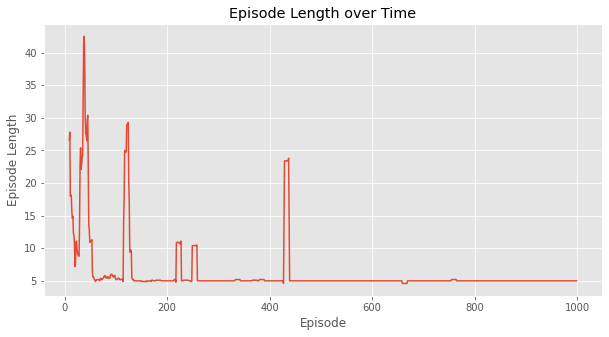

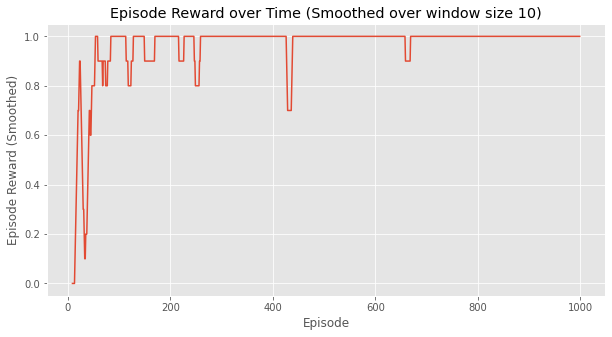

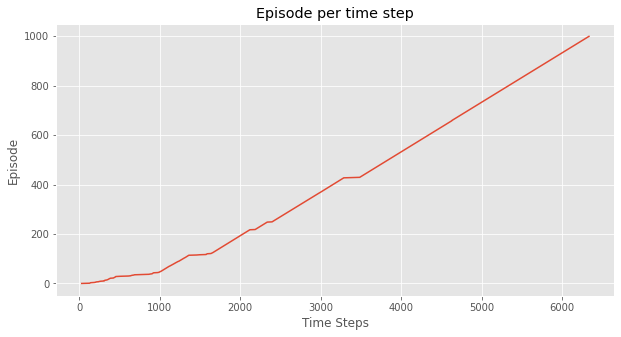

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
env = gym.make('FrozenLake-v0', is_slippery=False)
num_epi = 1000
Q, stats = sarsa_frozenlake(env, num_epi, 0.1, 0.001, 0.99, 0.5)

best_hundred = -np.inf
#Get an idea about the avg of the best hundred episodes before submitting on gym
for i in range(num_epi - 100):
    best_hundred = max(best_hundred, np.sum(stats.episode_rewards[i : i + 100]))
print("Avg. reward for best 100 eps:", best_hundred / 100.)

plotting.plot_episode_stats(stats, smoothing_window=10)

## Evaluation on Stochastic FrozenLake

100%|██████████| 1000/1000 [00:03<00:00, 283.35it/s]


Avg. reward for best 100 eps: 0.74


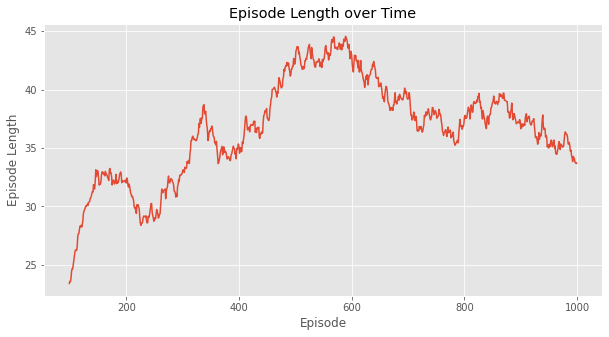

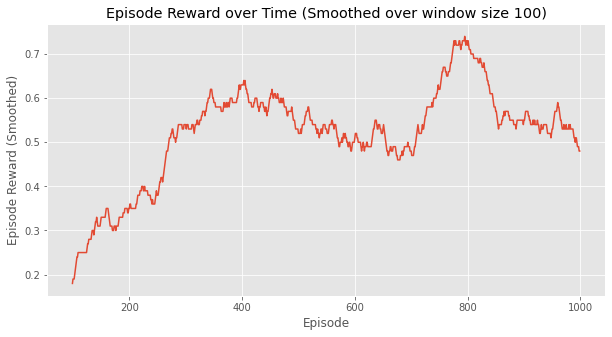

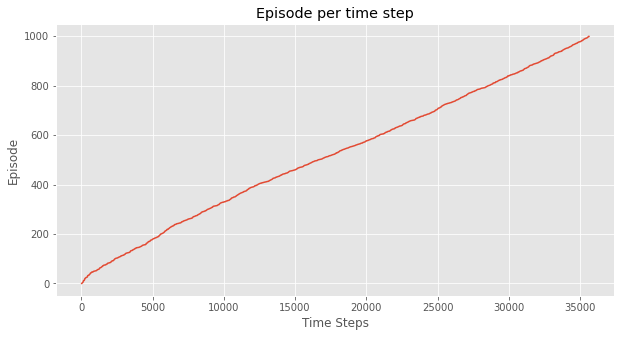

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
env = gym.make('FrozenLake-v0')
num_epi = 1000
Q, stats = sarsa_frozenlake(env, num_epi, 0.1, 0.001, 0.99, 0.5)

best_hundred = -np.inf
#Get an idea about the avg of the best hundred episodes before submitting on gym
for i in range(num_epi - 100):
    best_hundred = max(best_hundred, np.sum(stats.episode_rewards[i : i + 100]))
print("Avg. reward for best 100 eps:", best_hundred / 100.)

plotting.plot_episode_stats(stats, smoothing_window=100)

## Evaluation on Cliff Walking Environment

100%|██████████| 500/500 [00:01<00:00, 460.32it/s]


Avg. reward for best 100 eps: -21.87


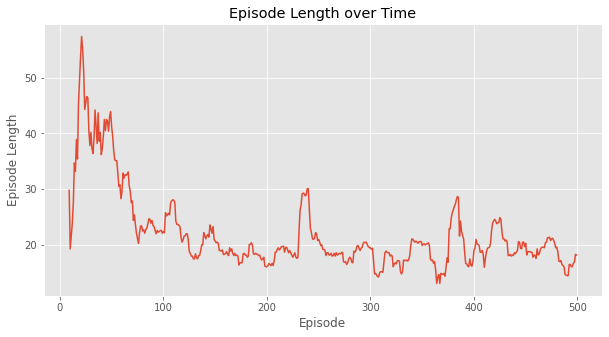

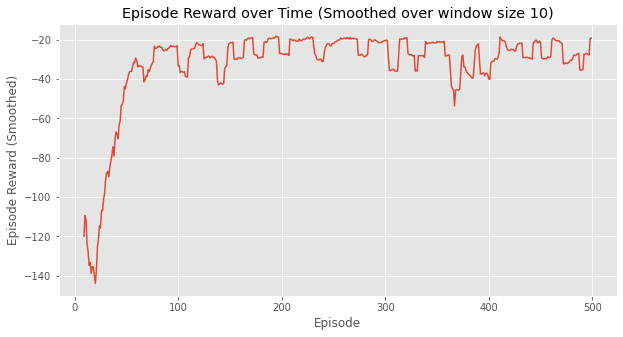

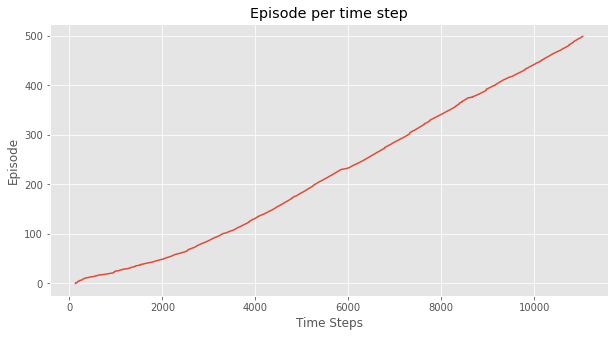

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
from lib.envs import CliffWalkingEnv

env = CliffWalkingEnv(4,12)
num_epi = 500
Q, stats = sarsa(env, num_epi, 0.1, 0.1, 1.0, 0.5)

best_hundred = -np.inf
#Get an idea about the avg of the best hundred episodes before submitting on gym
for i in range(num_epi - 100):
    best_hundred = max(best_hundred, np.sum(stats.episode_rewards[i : i + 100]))
print("Avg. reward for best 100 eps:", best_hundred / 100.)

plotting.plot_episode_stats(stats, smoothing_window=10)